In [1]:
import sym_tensor
import torch
import numpy as np
import sym_tensor.ops as st_ops

# Contents
(Links work only when you run the notebook)
- [Tensor basics](#Tensor-basics)
- [U(1) symmetry](#U(1)-symmetry)
- [Differentiable programming](#Differentiable-programming)
- [Gradient descent demo](#Gradient-descent-demo) (new)

# Tensor basics
A symmetric tensor is defined by its elements, quantum numbers (`charges`) and symmetry group (`ZN`). 
To initialize a `Z2`-symmetric matrix, run

In [2]:
charges = [
  [
    [0,2],
    [1,2]
  ],[
    [0,2],
    [1,2]
  ]
]

# Use elements=None to initialize with random elements
T = sym_tensor.newtensor(elements=None, charges=charges, ZN=2)
print(T)

2-D SymTensor (4, 4):
|  Free elements: 8 / 16 (50% of total) in 2 blocks 
|  ZN: 2 
|  Totalcharge: 0 
|  Readorder: [0, 1] 
 
Quantum numbers on each leg:
                 +-----+
( 0): [ 0, 1 ] --|     |-- ( 1): [ 0, 1 ]
                 +-----+



A `Z2`-symmetric matrix can be represented in block-diagonal form; in this case by two 2x2 blocks. Every symmetric tensor can be reshaped to a block-diagonal matrix by fusing indices together:

In [3]:
# Choose [0] as the left index, [1] as the right index and 'n' (irrelevant for Z2)
blocks, *meta = T.get_blocks(left_legs=[0], right_legs=[1], side='n') # The metadata is necessary to reverse the reshaping
for b in blocks:
    print(b)
T_full = T.to_full() # Embed the blocks in a matrix (only Z2 matrices for now supported)
print(T_full)

tensor([[0.8911, 0.0553],
        [0.0132, 0.3870]])
tensor([[0.9066, 0.0323],
        [0.6183, 0.6328]])
tensor([[0.8911, 0.0553, 0.0000, 0.0000],
        [0.0132, 0.3870, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.9066, 0.0323],
        [0.0000, 0.0000, 0.6183, 0.6328]])


To multiply tensors together, there are several options:

In [4]:
T2 = T.copy() # No shared memory

# Ncon
res = st_ops.ncon([T,T2], ([-1,1],[1,-2]))
print(res.to_full())

# Mult (arguments are the legs to be contracted on each tensor)
res = T.mult(T2, [1], [0])
print(res.to_full())

# Matrix product (in general: contract over last index of T and first index of T2)
res = T @ T2
print(res.to_full())

# Full result
print(T_full @ T_full)

tensor([[0.7947, 0.0707, 0.0000, 0.0000],
        [0.0169, 0.1505, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.8420, 0.0497],
        [0.0000, 0.0000, 0.9518, 0.4204]])
tensor([[0.7947, 0.0707, 0.0000, 0.0000],
        [0.0169, 0.1505, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.8420, 0.0497],
        [0.0000, 0.0000, 0.9518, 0.4204]])
tensor([[0.7947, 0.0707, 0.0000, 0.0000],
        [0.0169, 0.1505, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.8420, 0.0497],
        [0.0000, 0.0000, 0.9518, 0.4204]])
tensor([[0.7947, 0.0707, 0.0000, 0.0000],
        [0.0169, 0.1505, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.8420, 0.0497],
        [0.0000, 0.0000, 0.9518, 0.4204]])


In [5]:
# SVD (left_legs, right_legs, number of singular values to keep, absorb s left/right/not)
u,s,v = T.svd([0], [1], n=np.inf, absorb='n')
print((u@s@v.t()).to_full()) # Equal to T itself
print(T.allclose(u@s@v.t()))

tensor([[0.8911, 0.0553, 0.0000, 0.0000],
        [0.0132, 0.3870, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.9066, 0.0323],
        [0.0000, 0.0000, 0.6183, 0.6328]])
True


## U(1) symmetry
The continuous `U(1)` symmetry can be approximated by a `ZN` symmetry with large enough `N`. Initialize a tensor like:

In [6]:
charges = [
  [
    [1,1],
    [35,1]
  ],[
    [0,1],
    [1,1],
    [35,1]
  ],[
    [0,1],
    [1,1],
    [35,1]
  ]
]

# Use elements=None to initialize with random elements
T = sym_tensor.newtensor(elements=None, charges=charges, ZN=36)
print(T)

3-D SymTensor (2, 3, 3):
|  Free elements: 4 / 18 (22% of total) in 4 blocks 
|  ZN: 36 
|  Totalcharge: 0 
|  Readorder: [0, 1, 2] 
 
Quantum numbers on each leg:
                     +-----+
( 0):    [ 1, 35 ] --|     |-- ( 2): [ 0, 1, 35 ]
( 1): [ 0, 1, 35 ] --|     |
                     +-----+



In [7]:
blocks, *meta = T.get_blocks(left_legs=[0,1], right_legs=[2], side='n') # The metadata is necessary to reverse the reshaping
for i,b in enumerate(blocks):
    if b.numel() > 0:
        print("Quantum number: ", i)
        print(b)

Quantum number:  0
tensor([[0.6956],
        [0.9434]])
Quantum number:  1
tensor([[0.0927]])
Quantum number:  35
tensor([[0.7140]])


The same information can be obtained by

In [8]:
# Reshaped as matrix with indices 0 and 1 fused
T.show_block_structure([0,1], [2])

# As tensor
T.show_block_structure()

Matrix block structure with combined indices (0, 1) x (2,)
  0: Size (2, 1)     block with quantum numbers [0, 0]     (2    elements)
  1: Size (1, 1)     block with quantum numbers [1, 1]     (1    elements)
  2: Size (1, 1)     block with quantum numbers [35, 35]   (1    elements)
---->    4 elements in total
Tensor block structure (4 blocks)
  0 (  3): Size (1, 1, 1) block with quantum numbers [35, 1, 0]           (1   elements)
  1 (  4): Size (1, 1, 1) block with quantum numbers [1, 35, 0]           (1   elements)
  2 (  7): Size (1, 1, 1) block with quantum numbers [35, 0, 1]           (1   elements)
  3 ( 12): Size (1, 1, 1) block with quantum numbers [1, 0, 35]           (1   elements)
---->    4 elements in total


## Hamiltonian initizalization (automatic)
For the automatic conversion of a Hamiltonian (or other operators) in full array format to a symmetric tensor, we can use the `symmetrize_operator` function:

In [9]:
H_Heis = np.array([
    [0.25, 0, 0, 0],
    [0, -0.25, 0.5, 0],
    [0, 0.5, -0.25, 0],
    [0, 0, 0, 0.25]
])

# These represent the quantum numbers on each physical index
# For a spin-1/2 system with U(1) symmetry (approximated by Z36), the 
# basis states (up,down) correspond to quantum numbers (1,-1) mod ZN = (1,35)
phys_charges = [1,35]

# Either give the operator in matrix-form (bra indices, ket indices):
H_Heis_symmetric = sym_tensor.symmetrize_operator(op=H_Heis, phys_charges=phys_charges, ZN=36)
print('Elements of H: ', H_Heis_symmetric.data)
print(H_Heis_symmetric)
H_Heis_symmetric.show_block_structure()

# Or in tensor format, with an index for each physical leg:
H_Heis = np.reshape(H_Heis, [2,2,2,2])
H_Heis_symmetric = sym_tensor.symmetrize_operator(op=H_Heis, phys_charges=phys_charges, ZN=36)
print('\nElements of H: ', H_Heis_symmetric.data)
print(H_Heis_symmetric)

Elements of H:  tensor([ 0.2500,  0.5000, -0.2500, -0.2500,  0.5000,  0.2500])
4-D SymTensor (2, 2, 2, 2):
|  Free elements: 6 / 16 (37% of total) in 6 blocks 
|  ZN: 36 
|  Totalcharge: 0 
|  Readorder: [0, 1, 2, 3] 
 
Quantum numbers on each leg:
                  +-----+
( 0): [ 1, 35 ] --|     |-- ( 2): [ 1, 35 ]
( 1): [ 1, 35 ] --|     |-- ( 3): [ 1, 35 ]
                  +-----+

Tensor block structure (6 blocks)
  0 (  3): Size (1, 1, 1, 1) block with quantum numbers [35, 35, 1, 1]       (1   elements)
  1 (  5): Size (1, 1, 1, 1) block with quantum numbers [35, 1, 35, 1]       (1   elements)
  2 (  6): Size (1, 1, 1, 1) block with quantum numbers [1, 35, 35, 1]       (1   elements)
  3 (  9): Size (1, 1, 1, 1) block with quantum numbers [35, 1, 1, 35]       (1   elements)
  4 ( 10): Size (1, 1, 1, 1) block with quantum numbers [1, 35, 1, 35]       (1   elements)
  5 ( 12): Size (1, 1, 1, 1) block with quantum numbers [1, 1, 35, 35]       (1   elements)
---->    6 elements in t

## Covariant tensors
If you want to, for example, write a spin-flip operator as SymTensor, it will not be possible with a `U(1)`-invariant tensor, since it contains exactly the elements that are not allowed by the symmetry.
In order to still make such a SymTensor, you can attach an extra index to the tensor that carries a nontrivial quantum number, such that the total charge `Q_in - Q_out` is still conserved:

In [10]:
Splus = np.array([[0,1],[0,0]])
print("S+ operator:")
print(Splus)

S+ operator:
[[0 1]
 [0 0]]


The SymTensor will have only two elements that are allowed to be nonzero:

In [11]:
operator_el = np.array([[1,2],[3,4]])
print("General operator:")
print(operator_el)
print("")

op = sym_tensor.symmetrize_operator(operator_el, phys_charges=[1,35], ZN=36)
# Tensor with 2 allowed nonzero elements, namely the diagonal elements
# of the operator in matrix form
print(op)
print(op.data) # [1, 4]
print("")

General operator:
[[1 2]
 [3 4]]

2-D SymTensor (2, 2):
|  Free elements: 2 / 4 (50% of total) in 2 blocks 
|  ZN: 36 
|  Totalcharge: 0 
|  Readorder: [0, 1] 
 
Quantum numbers on each leg:
                  +-----+
( 0): [ 1, 35 ] --|     |-- ( 1): [ 1, 35 ]
                  +-----+

tensor([1., 4.])



Now make a new tensor with an additional index with quantum number +2 or -2
Why ±2? Because in the code there are no fractional quantum numbers, so spin-up corresponds to +1 (not +1/2). The S+ operator changes spin-down (-1) to spin-up (+1), so the difference is +2.

In [12]:
charges_with_extra_leg = [[[1,1],[35,1]], [[1,1],[35,1]], [[2,1]]]
op = sym_tensor.newtensor(charges=charges_with_extra_leg, ZN=36)

# Note that now there's only a single allowed nonzero element - just like the 
# the S+ operator
print(op)

# Make it S+:
op.data[0] = 1

3-D SymTensor (2, 2, 1):
|  Free elements: 1 / 4 (25% of total) in 1 blocks 
|  ZN: 36 
|  Totalcharge: 0 
|  Readorder: [0, 1, 2] 
 
Quantum numbers on each leg:
                  +-----+
( 0): [ 1, 35 ] --|     |-- ( 2):     [ 2 ]
( 1): [ 1, 35 ] --|     |
                  +-----+



The other way of doing this is by using the `totalcharge` property, which can be set to ±2 for this example. However this property is not yet fully supported in the code so that may cause some problems.

## Hamiltonian initialization (manual)
When building a Hamiltonian by hand with a nontrivial symmetry, the blocks of the tensor have be matched with the right elements of the Hamiltonian.
Here we use a Heisenberg Hamiltonian as an example. The basis is the standard spin basis {(up,up), (up,down), (down,up), (down,down)}, which can be identified with the set of quantum numbers {(1,1), (1,-1), (-1,1), (-1,-1)}.
The 4x4 (2-site) Hamiltonian can be reshaped to tensor form 2x2x2x2 where each index connects to a physical index of a tensor network. Each index then runs over the quantum numbers (1,-1) and will be given a `charge` of [[1,1],[35,1]] when we approximate the `U(1)` symmetry by `Z36`.  

In [13]:
H_Heis = np.array([
    [0.25, 0, 0, 0],
    [0, -0.25, 0.5, 0],
    [0, 0.5, -0.25, 0],
    [0, 0, 0, 0.25]
])
print(H_Heis)

[[ 0.25  0.    0.    0.  ]
 [ 0.   -0.25  0.5   0.  ]
 [ 0.    0.5  -0.25  0.  ]
 [ 0.    0.    0.    0.25]]


Now we need to identify all elements with the right quantum numbers. The top-left element maps an (up, up) state to an (up, up) state, corresponding to quantum numbers ( (1,1), (1,1) ).
The element on its bottom right corner (-0.25) maps (up,down) -> (up,down), so quantum numbers ( (1, -1), (1, -1) ).
Let's make a SymTensor with (±1) charges on each leg and inspect the nonzero blocks:

In [14]:
H = sym_tensor.newtensor(charges=4*[[[1,1],[35,1]]], ZN=36)
H.show_block_structure()

Tensor block structure (6 blocks)
  0 (  3): Size (1, 1, 1, 1) block with quantum numbers [35, 35, 1, 1]       (1   elements)
  1 (  5): Size (1, 1, 1, 1) block with quantum numbers [35, 1, 35, 1]       (1   elements)
  2 (  6): Size (1, 1, 1, 1) block with quantum numbers [1, 35, 35, 1]       (1   elements)
  3 (  9): Size (1, 1, 1, 1) block with quantum numbers [35, 1, 1, 35]       (1   elements)
  4 ( 10): Size (1, 1, 1, 1) block with quantum numbers [1, 35, 1, 35]       (1   elements)
  5 ( 12): Size (1, 1, 1, 1) block with quantum numbers [1, 1, 35, 35]       (1   elements)
---->    6 elements in total


Note that there are 6 blocks of size 1. One important remark is that the charges on the outgoing indices [2,3] are *conjugated* (in the code the 'arrows' are always pointed inwards), so in the first block [35,35,1,1] corresponds to ( (-1, -1), (-1, -1) ), which is the element that maps (down,down)->(down,down) - the element on the bottom right of the Hamiltonian (0.25).
We can then identify each block with a matrix element:

In [15]:
data = torch.zeros(6)
data[0] = H_Heis[3,3] # (down,down) -> (down,down)
data[1] = H_Heis[2,1] # (up,down)   -> (down,up)
data[2] = H_Heis[1,1] # (up,down)   -> (up,down)
data[3] = H_Heis[2,2] # (down,up)   -> (down,up)
data[4] = H_Heis[1,2] # (down,up)   -> (up,down)
data[5] = H_Heis[0,0] # (up,up)     -> (up,up)
H.data = data
print('Elements of H: ', H.data)
H.show_block_structure(left_legs=[0,1], right_legs=[2,3])

Elements of H:  tensor([ 0.2500,  0.5000, -0.2500, -0.2500,  0.5000,  0.2500])
Matrix block structure with combined indices (0, 1) x (2, 3)
  0: Size (2, 2)     block with quantum numbers [0, 0]     (4    elements)
  1: Size (1, 1)     block with quantum numbers [2, 2]     (1    elements)
  2: Size (1, 1)     block with quantum numbers [34, 34]   (1    elements)
---->    6 elements in total


# Differentiable programming
Within Torch, all tensor operations should be differentiable in order to obtain gradients. Turn on the tracking of gradients:

In [16]:
T.requires_grad = True
print(T) # Note that now the gradient will be tracked

3-D SymTensor (2, 3, 3):
|  Free elements: 4 / 18 (22% of total) in 4 blocks 
|  ZN: 36 
|  Totalcharge: 0 
|  Readorder: [0, 1, 2] 
|  Requires gradient: True 
 
Quantum numbers on each leg:
                     +-----+
( 0):    [ 1, 35 ] --|     |-- ( 2): [ 0, 1, 35 ]
( 1): [ 0, 1, 35 ] --|     |
                     +-----+



In [17]:
T2 = sym_tensor.newtensor(elements=None, charges=charges, ZN=36)
T2 = T2.conj() # Take the hermitian conjugate
nrm = T.mult(T2, [0,1,2], [0,1,2]) # Full contraction to a scalar
print(nrm) # Note that now the gradient function has been stored

1-D SymTensor (1,):
|  Free elements: 1 / 1 (100% of total) in 1 blocks 
|  ZN: 36 
|  Totalcharge: 0 
|  Readorder: [0] 
|  Requires gradient: True 
|  Gradient function: <torch.autograd.function.MultBackward object at 0x120c8b458> 
 
Quantum numbers on each leg:
              +-----+
( 0): [ 0 ] --|     |
              +-----+



In [18]:
# Backpropagation is the same as with regular torch Tensors
nrm.backward()
print(T.grad) # The gradient will be stored as a raw torch Tensor

tensor([0.9855, 0.4243, 0.9606, 0.6537])


The methods defined for SymTensor objects automatically determine whether they should be wrapped into a Torch autograd function (defined in `ops.py`) by checking the `T.requires_grad` property.
A method which is differentiable follows this general structure:

In [19]:
%%script false --no-raise-error
# tensors.py
# wrap_grad decorator wraps function in autograd operation if necessary 
# ('Max' in ops.py in this case)
# The decorator can be bypassed by adding the nograd=True keyword argument 
# T.max(nograd = True)
# or by calling the equivalent underscore variant:
# T.max_()
# When the tensor does not have the property requireds_grad==True, the gradient
# is never computed, so the explicit bypass is almost never necessary.
@_Decorators.wrap_grad(st_ops.Max)
def max(self): # Implementation on tensor level
    """ Largest element """
    max_el = self.data.max().unsqueeze(0).detach().clone()
    T = newtensor(elements=None, charges=[[[0,1]]], ZN=self.ZN, totalcharge=self.totalcharge)
    T.data = max_el
    return T

# ops.py
class Max(torch.autograd.Function):
    @staticmethod
    def forward(ctx, tensor):
        res = tensor.max_() # Basic operation on tensor (note the underscore)
        
        # Save information for backward pass
        ctx.intermediate_results = (tensor, res)
        
        # In some operations, only the metadata of the SymTensor needs to 
        # be saved, since Torch already saves the elements of the output.
        # res.meta contains all information of the resulting SymTensor 
        # (except the elements) that can be used to reconstruct a SymTensor
        # in the backward pass
        # Saving the information would then be something like:
        # ctx.intermediate_results = (res.meta)
        
        return res

    @staticmethod
    def backward(ctx, grad_output):
        # Backward pass, which receives the grad_output in the form of a 
        # regular Torch Tensor. If necessary, we cast the grad_output back
        # to a SymTensor like this:
        # (meta) = ctx.intermediate_results
        # tensor = tensors.from_meta(meta, elements=grad_output)
        (tensor, res) = ctx.intermediate_results
        tensor = tensor.copy()
        new_data = torch.zeros_like(tensor.data)
        tensor.data = new_data.masked_fill(tensor.data == res.data, grad_output.squeeze())
        return res

Most of the elementwise functions can be simply be implemented by calling the equivalent Torch function on the elements:

In [20]:
def __add__(self, other):
    return self._elem_function(torch.Tensor.__add__, other)

`T._elem_function` makes sure the elements are in the correct order, then calls the corresponding torch.Tensor function (here `torch.Tensor.__add__`) on the elements and finally calls `T.fill_data` to reconstruct the SymTensor from the elements.

# Gradient descent demo
We can put the SymTensors to work in a simple 2-site Heisenberg chain example. 
In this case, there are two variable tensors, for which we construct (1) a torch.nn.Parameter with the elements and (2) a corresponding SymTensor that is filled with the elements and used in the rest of the code.
Note that since `T.fill_data` is differentiable, the gradient on the SymTensors are automatically propagated to the Parameter objects.

In [21]:
# models.py
from torch import nn
class TwoSiteHeis(nn.Module):
    def __init__(self, elems_A=None, elems_B=None):
        super(TwoSiteHeis, self).__init__()
        H_Heis = np.array([
            [0.25, 0, 0, 0],
            [0, -0.25, 0.5, 0],
            [0, 0.5, -0.25, 0],
            [0, 0, 0, 0.25]
            ])
        phys_charges = [1,35]
        self.H = sym_tensor.symmetrize_operator(op=H_Heis, phys_charges=phys_charges, ZN=36)
        
        # A and B are simple U(1) MPS tensors that form a two-site chain
        ch_A = ch_B = [[[1,1],[35,1]], [[0,1],[1,1],[35,1]]]
        self.A = sym_tensor.newtensor(elements=elems_A, charges=ch_A, ZN=36)
        self.B = sym_tensor.newtensor(elements=elems_B, charges=ch_B, ZN=36)

        if elems_A is None:
            self.elems_A = nn.Parameter(self.A.data)
        if elems_B is None:
            self.elems_B = nn.Parameter(self.B.data)

    def forward(self, elems_A=None, elems_B=None):
        # The elements can be given as optional arguments so that the gradient 
        # of the full forward pass can be checked numerically
        # Normally, just take the tensors that are stored in the model
        if elems_A is not None:
            self.elems_A = elems_A
        if elems_B is not None:
            self.elems_B = elems_B

        # This is an important step: it copies the elements into the SymTensor 
        # in such a way that the operation remains differentiable
        # In the backward step, the gradient of A (SymTensor) will be propagated 
        # back to the gradient of elems_A (regular Torch Tensor)
        A = self.A.fill_data(self.elems_A)
        B = self.B.fill_data(self.elems_B)

        A_c = A.conj()
        B_c = B.conj()
        E = st_ops.ncon([A, B, self.H, A_c, B_c], ([1,2],[3,2],[1,3,4,5],[4,6],[5,6]))
        nrm = st_ops.ncon([A, B, A_c, B_c], ([1,2],[3,2],[1,4],[3,4]))
        E_normalized = E / nrm
        return E_normalized

Check if everything works:

In [22]:
m = TwoSiteHeis()

# Check the forward pass with two random initial tensors
elems_A = torch.nn.Parameter(torch.rand(m.A.numel(), requires_grad=True))
elems_B = torch.nn.Parameter(torch.rand(m.B.numel(), requires_grad=False))
E = m.forward(elems_A, elems_B) # Returns the energy in a SymTensor
print("Starting energy:", E.data)

# Notice that now the gradient of the SymTensor that is stored 
# on the model (m.A) is propagated to the Parameter object (elems_A)
E.backward()
print("Gradient of A:", elems_A.grad)
# Since the SymTensor is not a leaf in the graph, its gradient will be
# deleted, unless you set m.A.retain_grad()
print("Gradient of SymTensor m.A:", m.A.grad) # None

# Check the gradient of the full computation against a numerical gradient
print("Gradient check:", torch.autograd.gradcheck(m, (elems_A, elems_B)))

Starting energy: tensor([-0.1177])
Gradient of A: tensor([ 0.2022, -0.2456])
Gradient of SymTensor m.A: None
Gradient check: True


Model Parameters:
[Parameter containing:
tensor([0.1730, 0.4866], requires_grad=True), Parameter containing:
tensor([0.2344, 0.4912], requires_grad=True)]
Step 0 energy tensor([0.2291])
Step 1 energy tensor([-0.7500])
Step 2 energy tensor([-0.7500])
Step 3 energy tensor([-0.7500])
Step 4 energy tensor([-0.7500])
Step 5 energy tensor([-0.7500])
Step 6 energy tensor([-0.7500])
Step 7 energy tensor([-0.7500])
Step 8 energy tensor([-0.7500])
Step 9 energy tensor([-0.7500])
Final energy: tensor([-0.7500]) error: tensor([2.3562e-12])


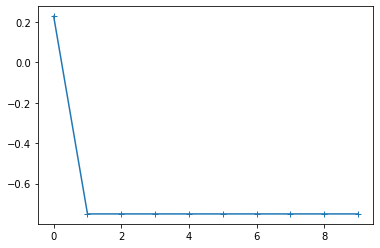

In [24]:
# main simulation script
m = TwoSiteHeis()
print("Model Parameters:")
print(list(m.parameters()))

learning_rate = 1

optimizer = torch.optim.LBFGS(m.parameters(), max_iter=10, lr=learning_rate)

def closure():
    optimizer.zero_grad()
    loss = m.forward()
    loss.backward()
    return loss

energies = []
for epoch in range(10):
    loss = optimizer.step(closure)
    print("Step", epoch, "energy", loss.data)
    energies.append(loss)

print("Final energy:", energies[-1].data, "error:", energies[-1].data--0.75)
import matplotlib.pyplot as plt
plt.plot(energies, '-+');